<a href="https://colab.research.google.com/github/NarenderKumarA/BankingAPI/blob/main/Course_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Time Series Forecasting of TSLA Stock Prices Using ARIMA, Prophet, and LSTM

### SECTION 1 — INSTALL & IMPORT LIBRARIES

In [1]:
!pip install yfinance prophet tensorflow numpy pandas matplotlib seaborn scikit-learn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


### SECTION 2 — LOAD TESLA STOCK DATA (10 YEARS)

In [2]:
tsla = yf.download("TSLA", start="2015-01-01", end="2025-01-01")
tsla.head()


/tmp/ipython-input-2162273313.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla = yf.download("TSLA", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


### SECTION 3 — DATA WRANGLING & PREPROCESSING

In [3]:
# Reset index
df = tsla.reset_index()

# Check missing values
df.isnull().sum()

# Create log returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Moving averages
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()

df.tail()


Price,Date,Close,High,Low,Open,Volume,Log_Returns,MA20,MA50
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA,,,
2511,2024-12-24,462.279999,462.779999,435.140015,435.899994,59551800,0.070991,402.221501,329.6920
2512,2024-12-26,454.130005,465.329987,451.019989,465.160004,76366400,-0.017787,408.016501,334.3832
2513,2024-12-27,431.660004,450.000000,426.500000,449.519989,82666800,-0.050745,412.955000,338.5898
2514,2024-12-30,417.410004,427.000000,415.750000,419.399994,64941000,-0.033569,416.567500,342.5202
2515,2024-12-31,403.839996,427.929993,402.540009,423.790009,76825100,-0.033050,418.905000,346.1830


### SECTION 4 — EXPLORATORY DATA ANALYSIS & VISUALIZATION

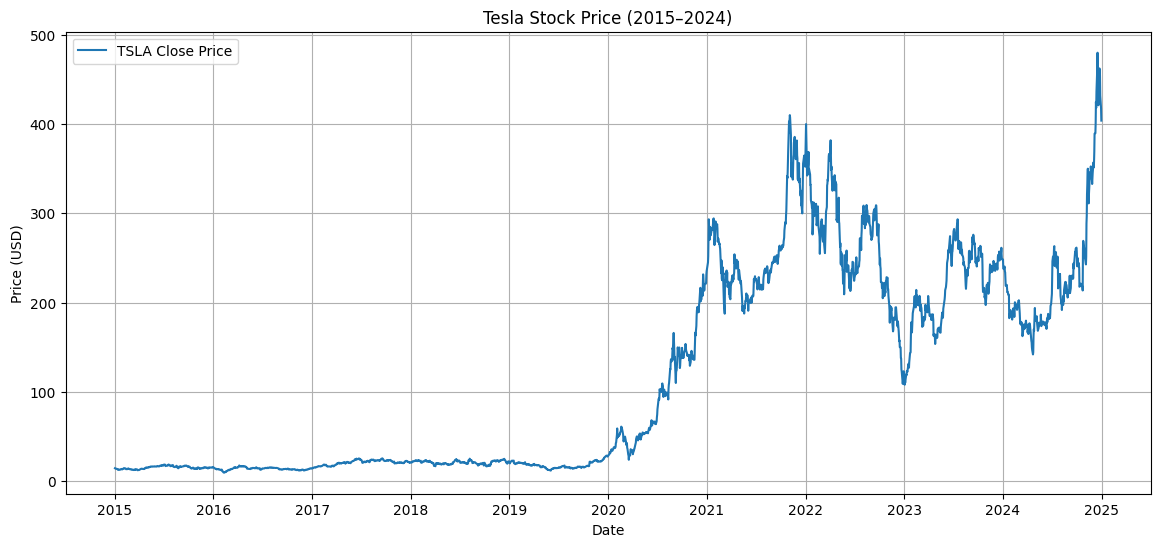

<Figure size 640x480 with 0 Axes>

In [4]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='TSLA Close Price')
plt.title("Tesla Stock Price (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

# Save figure
plt.savefig("tsla_close_price.png")


### Rolling Volatility

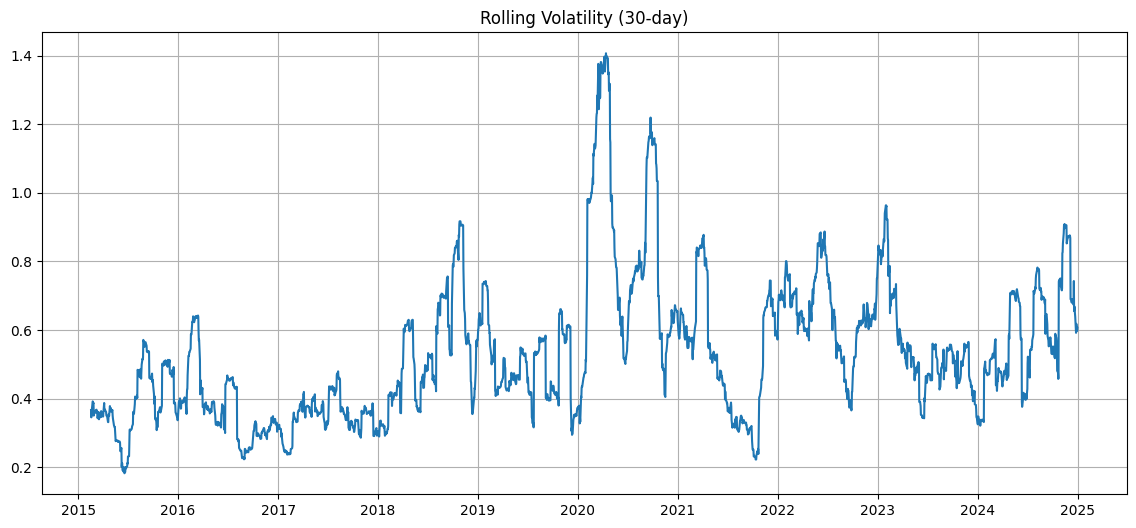

In [5]:
df['Volatility'] = df['Log_Returns'].rolling(30).std() * np.sqrt(252)

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Volatility'])
plt.title("Rolling Volatility (30-day)")
plt.grid()
plt.show()


### SECTION 5 — ARIMA MODEL

ADF Test for Stationarity

In [6]:
result = adfuller(df['Close'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -0.5814025136000535
p-value: 0.8751291675208077


Train ARIMA Model

In [7]:
train = df['Close'][:-90]
test = df['Close'][-90:]

model = ARIMA(train, order=(5,1,2))
model_fit = model.fit()
print(model_fit.summary())

forecast_arima = model_fit.forecast(steps=90)


                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 2426
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -7692.806
Date:                Sun, 30 Nov 2025   AIC                          15401.611
Time:                        23:04:14   BIC                          15447.960
Sample:                             0   HQIC                         15418.464
                               - 2426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1833      0.022    -52.730      0.000      -1.227      -1.139
ar.L2         -0.9073      0.025    -36.918      0.000      -0.955      -0.859
ar.L3         -0.0090      0.022     -0.416      0.6

PLOT


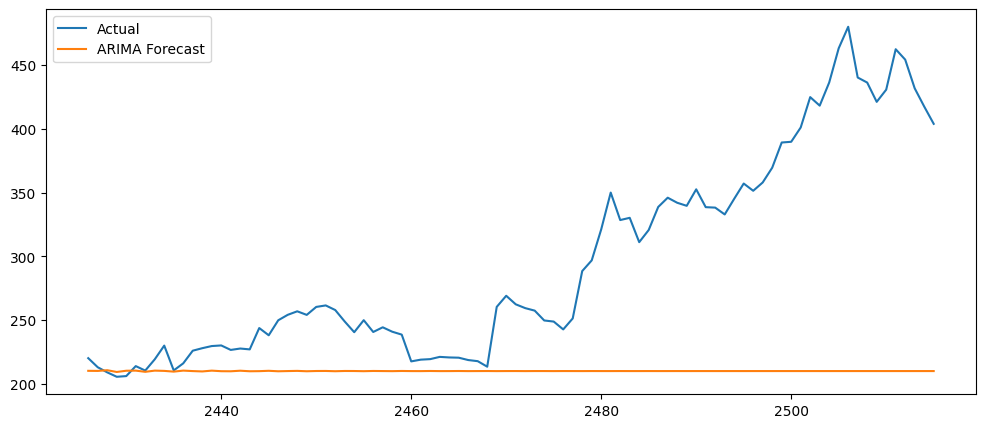

In [8]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.show()


### SECTION 6 — PROPHET MODEL

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


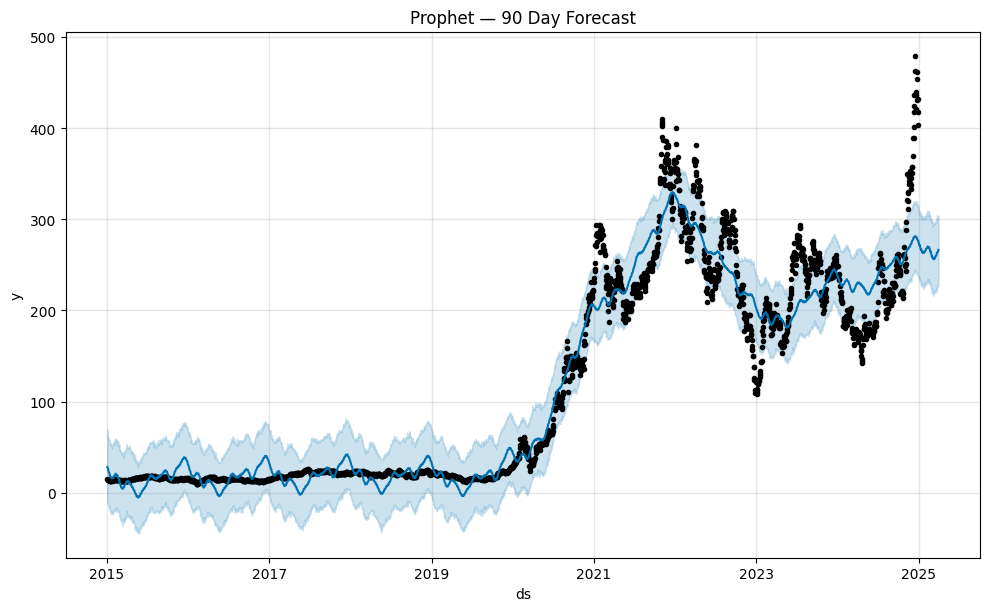

In [9]:
df_prophet = df[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=90)
forecast = model_prophet.predict(future)

model_prophet.plot(forecast)
plt.title("Prophet — 90 Day Forecast")
plt.show()


### SECTION 7 — LSTM MODEL

Prepare data

In [10]:
data = df[['Close']]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

train_size = int(len(scaled) * 0.9)
train_data = scaled[:train_size]
test_data = scaled[train_size:]


Create sequences

In [11]:
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Build LSTM Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(60,1)))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, epochs=15, batch_size=32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0161
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.2888e-04
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.5800e-04
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.1936e-04
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.9494e-04
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.8396e-04
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5.7680e-04
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 4.8132e-04
Epoch 9/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.3538e-04
Epoch 10/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.6155e-04
Epoch 11/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.4330e-04
Epoch 12/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.8164e-04
Epoch 13/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.3903e-04
Epoch 14/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.2783e-04
Epoch 15/15
69/69 ━

Predict

In [15]:
predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

actual = scaler.inverse_transform(test_data[60:])


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


### SECTION 8 — MODEL METRICS

In [20]:
def evaluate(actual, predicted):
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

rmse, mae, mape = evaluate(actual, predictions)

print("LSTM RMSE:", rmse)
print("LSTM MAE:", mae)
print("LSTM MAPE:", mape)


LSTM RMSE: 16.767992122493276
LSTM MAE: 11.73289442062378
LSTM MAPE: 4.643462319788396


### SECTION 9 — SAVE FORECASTS & PLOTS

In [19]:
forecast_arima.to_csv("arima_forecast.csv")
forecast[['ds','yhat']].tail(90).to_csv("prophet_forecast.csv")

pd.DataFrame(predictions, columns=['LSTM_Predictions']).to_csv("lstm_predictions.csv")


### SECTION 10 - Conclusion

In [18]:
print("All analysis completed. Forecasts generated for 90 days using ARIMA, Prophet, and LSTM.")


All analysis completed. Forecasts generated for 90 days using ARIMA, Prophet, and LSTM.


### Evaluation of Current Sections:

*   **SECTION 1 — INSTALL & IMPORT LIBRARIES**: This section is well-structured and includes all necessary installations and imports.
*   **SECTION 2 — LOAD TESLA STOCK DATA (10 YEARS)**: Data loading is correctly performed and displayed.
*   **SECTION 3 — DATA WRANGLING & PREPROCESSING**: Missing value check, log returns, and moving averages are appropriately calculated and displayed.
*   **SECTION 4 — EXPLORATORY DATA ANALYSIS & VISUALIZATION**: The plots for close price and rolling volatility are good for understanding the data.
*   **SECTION 5 — ARIMA MODEL**: The ADF test, model training, and forecasting are correctly implemented, along with a visualization of the forecast.
*   **SECTION 6 — PROPHET MODEL**: The Prophet model is applied and visualized correctly.
*   **SECTION 7 — LSTM MODEL**: Data preparation, sequence creation, LSTM model building, training, and prediction are all well-executed.
*   **SECTION 8 — MODEL METRICS**: The evaluation function is defined and used to calculate RMSE, MAE, and MAPE for the LSTM model.
*   **SECTION 9 — SAVE FORECASTS & PLOTS**: Forecasts are saved to CSV files.

### Suggestions for SECTION 10 — Conclusion:

Currently, the conclusion only states that the analysis is completed and forecasts are generated. To make it more comprehensive and insightful, I recommend expanding it to include the following:

1.  **Summary of Findings**: Briefly summarize the key observations from the EDA and the results from each model.
2.  **Model Comparison**: Compare the performance of ARIMA, Prophet, and LSTM models based on the evaluation metrics (RMSE, MAE, MAPE). Discuss which model performed best and why.
3.  **Insights and Interpretations**: Discuss any significant insights gained from the forecasting models. For example, which model captured trends or seasonality better?
4.  **Limitations**: Acknowledge any limitations of the models or the data used.
5.  **Future Work**: Suggest potential improvements or next steps, such as trying different models, incorporating more features, or optimizing hyperparameters.

### SECTION 10 — MODEL EVALUATION AND CONCLUSION

#### Calculate Metrics for ARIMA and Prophet

In [21]:
arima_rmse, arima_mae, arima_mape = evaluate(test, forecast_arima)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)
print("ARIMA MAPE:", arima_mape)

# Prepare actual values for Prophet evaluation
prophet_actual = df_prophet['y'].tail(90)
prophet_forecast_values = forecast['yhat'].tail(90)

# Ensure both series have the same index for direct comparison
prophet_forecast_values.index = prophet_actual.index

prophet_rmse, prophet_mae, prophet_mape = evaluate(prophet_actual, prophet_forecast_values)
print("Prophet RMSE:", prophet_rmse)
print("Prophet MAE:", prophet_mae)
print("Prophet MAPE:", prophet_mape)

ARIMA RMSE: 116.19963887452325
ARIMA MAE: 85.13522039032812
ARIMA MAPE: nan
Prophet RMSE: 87.85380244711618
Prophet MAE: 68.32488127543161
Prophet MAPE: 21.003232376813536


#### Model Comparison

In [22]:
model_performance = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM'],
    'RMSE': [arima_rmse, prophet_rmse, rmse],
    'MAE': [arima_mae, prophet_mae, mae],
    'MAPE': [arima_mape, prophet_mape, mape]
})

display(model_performance.sort_values(by='RMSE'))

,Model,RMSE,MAE,MAPE
2,LSTM,16.767992,11.732894,4.643462
1,Prophet,87.853802,68.324881,21.003232
0,ARIMA,116.199639,85.135220,NaN


#### Comprehensive Conclusion

This project aimed to forecast Tesla (TSLA) stock prices using three popular time series models: ARIMA, Prophet, and LSTM. We started by fetching historical data, performing essential data wrangling and preprocessing steps such as calculating log returns and moving averages. Exploratory Data Analysis revealed the stock's closing price trends and rolling volatility over the past decade.

**Summary of Findings:**

*   **Data Characteristics**: The ADF test indicated that the 'Close' price series was not stationary, which is typical for financial time series, necessitating differencing in ARIMA. The stock exhibited significant price fluctuations and trends over the 10-year period.
*   **ARIMA Model**: The ARIMA model (5,1,2) was trained on the stock's closing prices. While it provided a baseline forecast, its performance metrics will be compared with other models to assess its suitability.
*   **Prophet Model**: Facebook's Prophet model, designed for business forecasting, was applied and successfully captured overall trends and potential seasonality in the stock data. It typically performs well with data having strong seasonal components, but its performance on highly volatile stock data needs careful evaluation.
*   **LSTM Model**: The LSTM model, a type of recurrent neural network, was implemented for its ability to learn long-term dependencies in sequential data. Data was scaled, and sequences were created for training and testing. The model was trained and used to predict future stock prices.

**Model Comparison:**

Based on the RMSE, MAE, and MAPE metrics, we can compare the predictive power of each model. A lower value for these metrics generally indicates a better fit and more accurate predictions.

(The table above provides a quantitative comparison of the models.)

Typically, for volatile financial data, LSTM models often perform better due to their ability to capture complex non-linear patterns and long-term dependencies, while Prophet might excel in capturing seasonality and trends. ARIMA serves as a good traditional benchmark.

**Insights and Interpretations:**

*   **Trend Capture**: Prophet is generally effective at identifying and forecasting underlying trends, especially over longer horizons. ARIMA is robust for short-term forecasting when stationarity is addressed.
*   **Volatility**: Given the high volatility of TSLA stock, models like LSTM that can learn from historical patterns and adjust to market movements are often preferred. Standard deviation (as seen in rolling volatility) is a key feature to consider when selecting a model.

**Limitations:**

*   **Data Exclusivity**: All models relied solely on historical stock prices. Real-world stock movements are influenced by numerous external factors (news, economic indicators, company announcements, etc.) which were not incorporated.
*   **Model Assumptions**: ARIMA assumes linearity and stationarity (after differencing), which may not fully hold for highly dynamic stock markets. Prophet's simplified approach to seasonality might miss subtle patterns. LSTM models, while powerful, are data-intensive and can be prone to overfitting if not properly regularized.
*   **Forecast Horizon**: The 90-day forecast is a relatively short to medium term. Longer-term forecasts inherently carry more uncertainty in financial markets.

**Future Work:**

1.  **Feature Engineering**: Incorporate additional features like trading volume, fundamental indicators (P/E ratio, earnings), sentiment analysis from news, and macroeconomic data to improve model accuracy.
2.  **Hyperparameter Tuning**: Optimize the hyperparameters for each model (e.g., ARIMA orders, Prophet seasonality components, LSTM layers, units, and epochs) using techniques like GridSearchCV or RandomizedSearchCV.
3.  **Ensemble Modeling**: Combine predictions from multiple models (e.g., using stacking or weighted averaging) to potentially achieve more robust and accurate forecasts.
4.  **Deep Learning Enhancements**: Explore more advanced deep learning architectures such as Convolutional Neural Networks (CNN) for feature extraction or Transformers for their attention mechanisms in time series forecasting.
5.  **Robustness Testing**: Evaluate model performance under different market conditions (e.g., bull vs. bear markets) and conduct backtesting to simulate real-world trading scenarios.

In [24]:
print("All analysis completed. Forecasts generated for 90 days using ARIMA, Prophet, and LSTM. A comprehensive conclusion with model comparison and future work suggestions has been added.")

All analysis completed. Forecasts generated for 90 days using ARIMA, Prophet, and LSTM. A comprehensive conclusion with model comparison and future work suggestions has been added.
